# Question 1

In [15]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


In [3]:

train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')

# Separate labels and image pixels
train_labels = train_df.iloc[:, 0].values
train_images = train_df.iloc[:, 1:].values.astype(np.float32) / 255.0  # Normalize
test_labels = test_df.iloc[:, 0].values
test_images = test_df.iloc[:, 1:].values.astype(np.float32) / 255.0

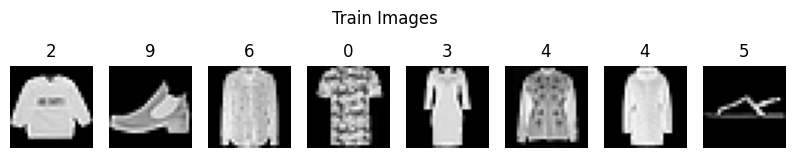

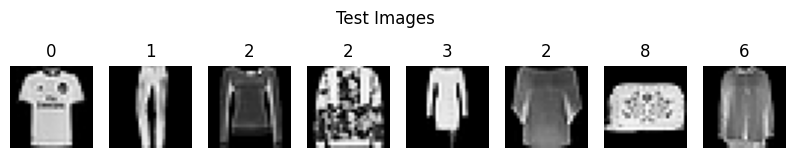

In [4]:
def show_images(images, labels, title):
    plt.figure(figsize=(10, 2))
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_images(train_images, train_labels, "Train Images")
show_images(test_images, test_labels, "Test Images")

In [5]:
# Fashion-EMNIST Label Mapping:
# Label : Class Name
#   0    : T-shirt/top
#   1    : Trouser
#   2    : Pullover
#   3    : Dress
#   4    : Coat
#   5    : Sandal
#   6    : Shirt
#   7    : Sneaker
#   8    : Bag
#   9    : Ankle boot
#
# Note: For autoencoders, we don’t use these labels — we only use the image data itself.

In [6]:
class FashionEMNISTDataset(Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images).reshape(-1, 1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], 0  # Dummy label, not needed for autoencoder

	•	“This cell defines a custom PyTorch Dataset class for our Fashion-EMNIST data.”
	•	“We pass the image data (as a NumPy array or DataFrame) into this class.”
	•	“Inside the constructor, we convert the images to PyTorch tensors and reshape them to the shape required by CNNs: (batch, channels, height, width) which is (N, 1, 28, 28).”
	•	“__len__ simply returns the number of images in the dataset.”
	•	“__getitem__ returns a single image at the given index, and a dummy label 0 since autoencoders are unsupervised and don’t require actual labels.”

In [7]:
train_dataset = FashionEMNISTDataset(train_images)
test_dataset = FashionEMNISTDataset(test_images)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [8]:

class Autoencoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=16):
        super(Autoencoder, self).__init__()
        hidden_dim = 128  # Intermediate layer dimension

        # -------- Encoder Weights and Biases --------
        self.W1 = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(hidden_dim))

        self.W2 = nn.Parameter(torch.randn(latent_dim, hidden_dim) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(latent_dim))

        # Layer 1: Fully connected input_dim → hidden_dim with ReLU
        # Layer 2: Fully connected hidden_dim → latent_dim (no activation)

        # -------- Decoder Weights and Biases --------
        self.W3 = nn.Parameter(torch.randn(hidden_dim, latent_dim) * 0.01)
        self.b3 = nn.Parameter(torch.zeros(hidden_dim))

        self.W4 = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.01)
        self.b4 = nn.Parameter(torch.zeros(input_dim))

        # Layer 3: Fully connected latent_dim → hidden_dim with ReLU
        # Layer 4: Fully connected hidden_dim → input_dim with Sigmoid (for output in [0,1])

    def encoder_forward(self, x):
        # x: [batch_size, 784]
        h1 = F.relu(torch.matmul(x, self.W1.T) + self.b1)
        z = torch.matmul(h1, self.W2.T) + self.b2
        return z
        # h1: [batch_size, hidden_dim]
        # z: [batch_size, latent_dim]

    def decoder_forward(self, z):
        # z: [batch_size, latent_dim]
        h2 = F.relu(torch.matmul(z, self.W3.T) + self.b3)
        x_hat = torch.sigmoid(torch.matmul(h2, self.W4.T) + self.b4)
        return x_hat
        # h2: [batch_size, hidden_dim]
        # x_hat: [batch_size, 784] (reconstructed image)

    def forward(self, x):
        # Flatten the image
        x = x.view(x.size(0), -1)  # [batch_size, 784]
        z = self.encoder_forward(x)
        x_hat = self.decoder_forward(z)
        return x_hat


In [9]:
def mse_loss(pred, target):
    return torch.mean((pred - target) ** 2)

def train_autoencoder(model, train_loader, test_loader, epochs=10, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Manually collect parameters (since we didn't use nn.Sequential)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            x_hat = model(x)
            loss = mse_loss(x_hat, x.view(x.size(0), -1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                x_hat = model(x)
                loss = mse_loss(x_hat, x.view(x.size(0), -1))
                test_loss += loss.item()
        test_losses.append(test_loss / len(test_loader))

        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}")

    return train_losses, test_losses

In [10]:
# Store a fixed batch of 8 train and test samples for consistent visual comparison
def get_fixed_samples(train_loader, test_loader, n=8):
    for x, _ in train_loader:
        fixed_train = x[:n]
        break
    for x, _ in test_loader:
        fixed_test = x[:n]
        break
    return fixed_train, fixed_test

# Save fixed samples globally
fixed_train_samples, fixed_test_samples = get_fixed_samples(train_loader, test_loader)

In [11]:
def visualize_fixed_reconstructions(model, fixed_samples, source="Train", latent_dim=16):
    model.eval()
    device = next(model.parameters()).device
    x = fixed_samples.to(device)

    with torch.no_grad():
        x_hat = model(x)

    fig, axes = plt.subplots(2, len(x), figsize=(2 * len(x), 4))
    for i in range(len(x)):
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
        axes[0, i].set_title(f"{source} {i}")
        axes[0, i].axis('off')

        axes[1, i].imshow(x_hat[i].view(28, 28).cpu(), cmap='gray')
        axes[1, i].set_title(f"Recon (z={latent_dim})")
        axes[1, i].axis('off')

    plt.suptitle(f"{source} Set: Original (Top) vs Reconstructed (Bottom), Latent Dim = {latent_dim}")
    plt.tight_layout()
    plt.show()

	•	“We set the model to evaluation mode using model.eval() and move the input images to the same device as the model.”
	•	“Then, without computing gradients (torch.no_grad()), we pass the images through the model to get their reconstructions x_hat.”

In [12]:
def plot_loss_curves(train_loss, test_loss, latent_dim):
    plt.figure(figsize=(8, 4))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"Training & Test Loss Curve (Latent Dim = {latent_dim})")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def visualize_reconstructions(model, data_loader, n=8):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        for x, _ in data_loader:
            x = x[:n].to(device)
            x_hat = model(x)
            break

    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(x_hat[i].view(28, 28).cpu(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()

Epoch 1 | Train Loss: 0.0581 | Test Loss: 0.0313
Epoch 2 | Train Loss: 0.0263 | Test Loss: 0.0240
Epoch 3 | Train Loss: 0.0227 | Test Loss: 0.0215
Epoch 4 | Train Loss: 0.0204 | Test Loss: 0.0195
Epoch 5 | Train Loss: 0.0188 | Test Loss: 0.0182
Epoch 6 | Train Loss: 0.0177 | Test Loss: 0.0173
Epoch 7 | Train Loss: 0.0168 | Test Loss: 0.0165
Epoch 8 | Train Loss: 0.0160 | Test Loss: 0.0158
Epoch 9 | Train Loss: 0.0153 | Test Loss: 0.0151
Epoch 10 | Train Loss: 0.0148 | Test Loss: 0.0146


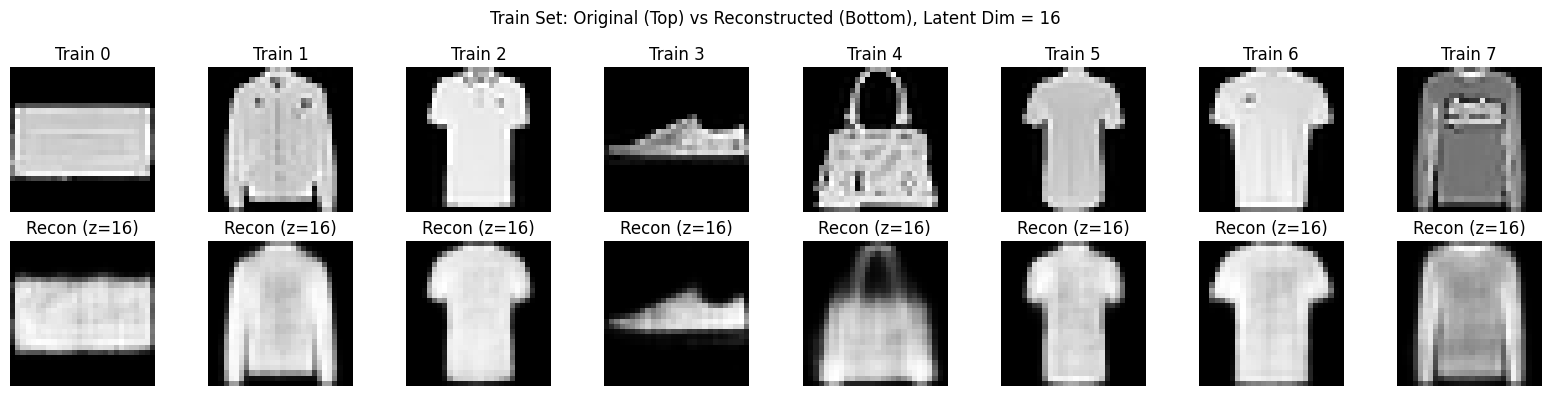

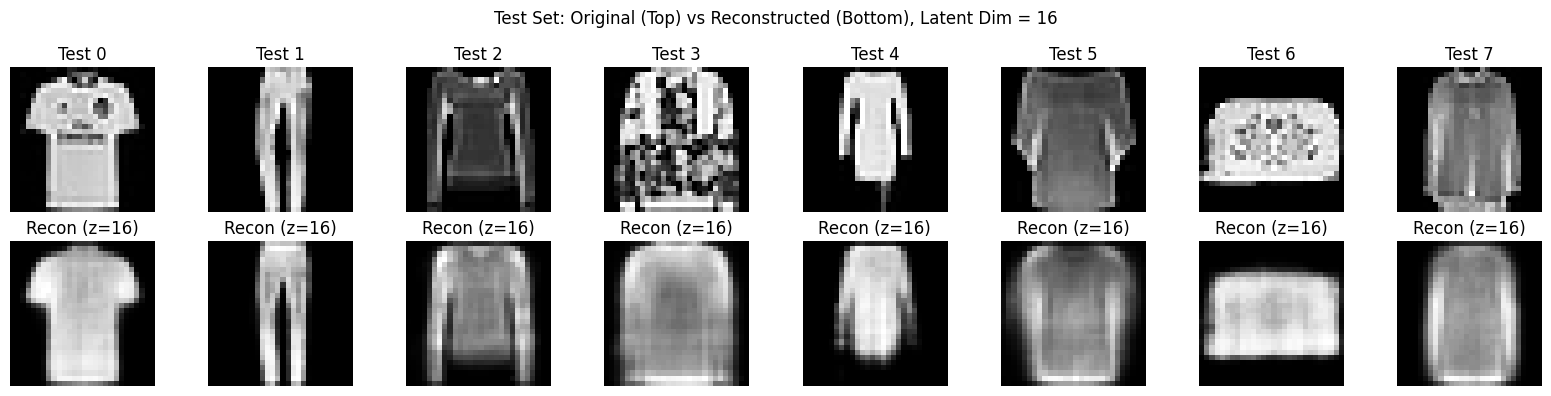

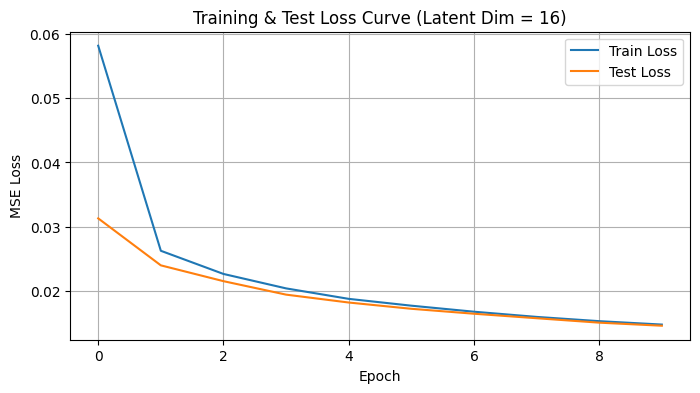

In [16]:
# Train model with latent dim = 16
model_16 = Autoencoder(latent_dim=16)
train_loss_16, test_loss_16 = train_autoencoder(model_16, train_loader, test_loader)
visualize_fixed_reconstructions(model_16, fixed_train_samples, "Train", latent_dim=16)
visualize_fixed_reconstructions(model_16, fixed_test_samples, "Test", latent_dim=16)
plot_loss_curves(train_loss_16, test_loss_16, latent_dim=16)

Epoch 1 | Train Loss: 0.0655 | Test Loss: 0.0322
Epoch 2 | Train Loss: 0.0250 | Test Loss: 0.0221
Epoch 3 | Train Loss: 0.0206 | Test Loss: 0.0194
Epoch 4 | Train Loss: 0.0185 | Test Loss: 0.0178
Epoch 5 | Train Loss: 0.0172 | Test Loss: 0.0166
Epoch 6 | Train Loss: 0.0161 | Test Loss: 0.0158
Epoch 7 | Train Loss: 0.0153 | Test Loss: 0.0151
Epoch 8 | Train Loss: 0.0146 | Test Loss: 0.0143
Epoch 9 | Train Loss: 0.0139 | Test Loss: 0.0137
Epoch 10 | Train Loss: 0.0134 | Test Loss: 0.0132


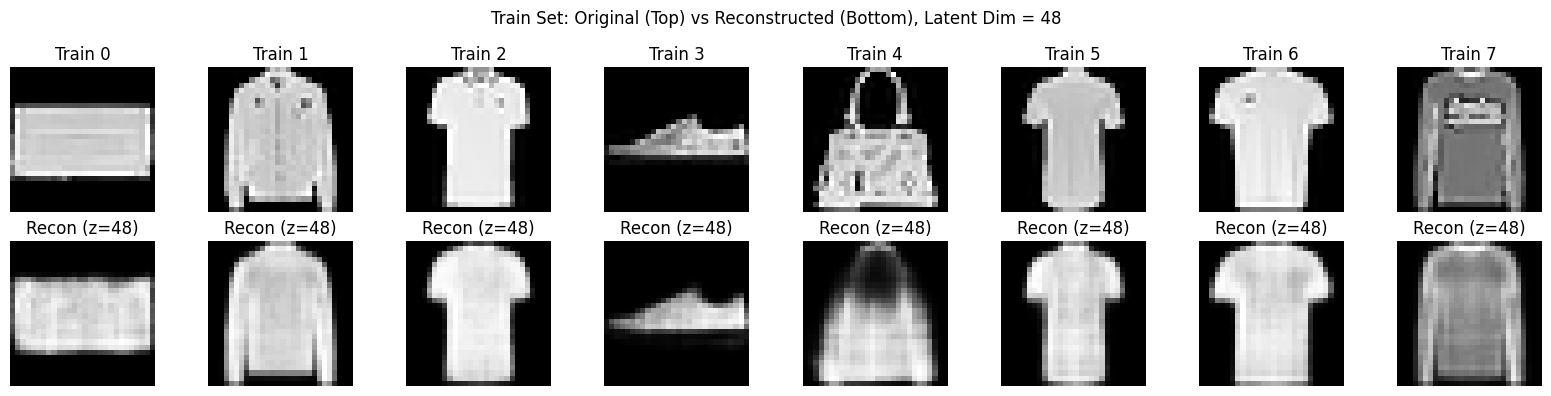

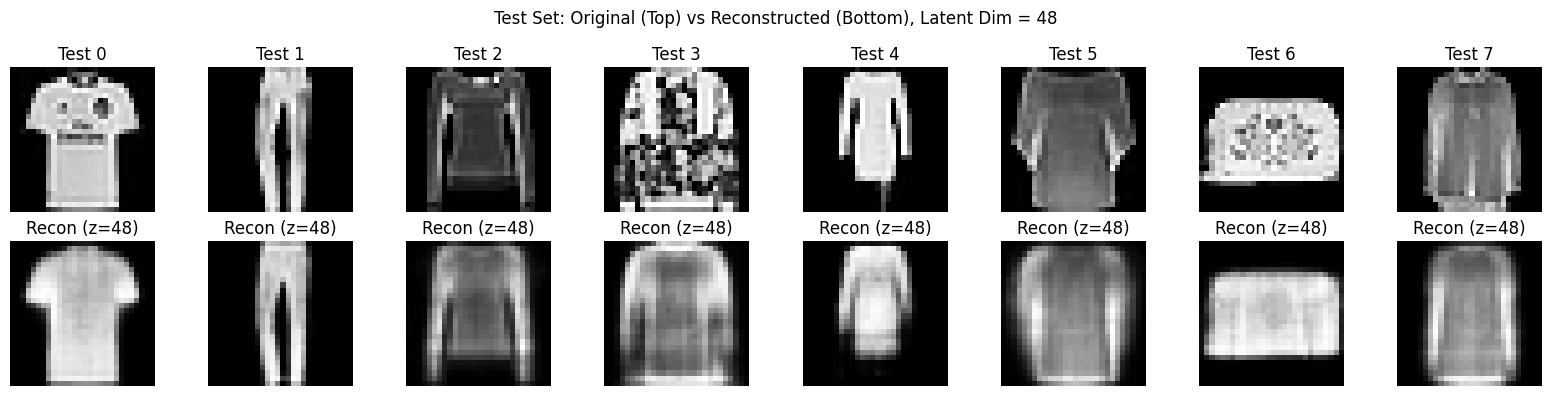

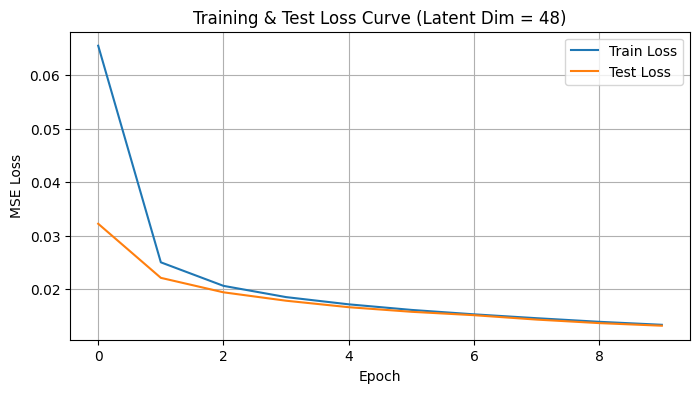

In [17]:
# Train model with latent dim = 48
model_48 = Autoencoder(latent_dim=48)
train_loss_48, test_loss_48 = train_autoencoder(model_48, train_loader, test_loader)
visualize_fixed_reconstructions(model_48, fixed_train_samples, "Train", latent_dim=48)
visualize_fixed_reconstructions(model_48, fixed_test_samples, "Test", latent_dim=48)
plot_loss_curves(train_loss_48, test_loss_48, latent_dim=48)

**(b)**

In [22]:
def interpolate_latent_space(model_16, model_48, data_loader, pairs=4, steps=5):
    """
    For each pair of images:
    - Encode them into latent space
    - Interpolate linearly between the two latent vectors
    - Decode and visualize each interpolated image

    Works for both latent dimensions.
    """
    device = next(model_16.parameters()).device
    model_16.eval()
    model_48.eval()

    # Fetch a batch of inputs
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)[:pairs * 2]  # Get 2 images per pair
            break

    fig, axs = plt.subplots(pairs, steps * 2, figsize=(steps * 2.2, pairs * 2.2))

    for i in range(pairs):
        x1, x2 = x[2 * i], x[2 * i + 1]

        # Flatten inputs
        x1_flat = x1.view(1, -1)
        x2_flat = x2.view(1, -1)

        # Encode with model_16
        z1_16 = model_16.encoder_forward(x1_flat)
        z2_16 = model_16.encoder_forward(x2_flat)

        # Encode with model_48
        z1_48 = model_48.encoder_forward(x1_flat)
        z2_48 = model_48.encoder_forward(x2_flat)

        for j, alpha in enumerate(torch.linspace(0, 1, steps)):
            # Interpolation for 16D model
            z_interp_16 = (1 - alpha) * z1_16 + alpha * z2_16
            x_interp_16 = model_16.decoder_forward(z_interp_16)
            # Detach the tensor from the computation graph before converting to NumPy
            axs[i, j].imshow(x_interp_16.view(28, 28).cpu().detach().numpy(), cmap='gray')
            axs[i, j].axis('off')
            if i == 0:
                axs[i, j].set_title(f"α={alpha:.2f}\n(16d)", fontsize=8)

            # Interpolation for 48D model
            z_interp_48 = (1 - alpha) * z1_48 + alpha * z2_48
            x_interp_48 = model_48.decoder_forward(z_interp_48)
            # Detach the tensor from the computation graph before converting to NumPy
            axs[i, j + steps].imshow(x_interp_48.view(28, 28).cpu().detach().numpy(), cmap='gray')
            axs[i, j + steps].axis('off')
            if i == 0:
                axs[i, j + steps].set_title(f"α={alpha:.2f}\n(48d)", fontsize=8)

    plt.suptitle("Latent Space Interpolation: 16D (Left) vs 48D (Right)", fontsize=14)
    plt.tight_layout()
    plt.show()

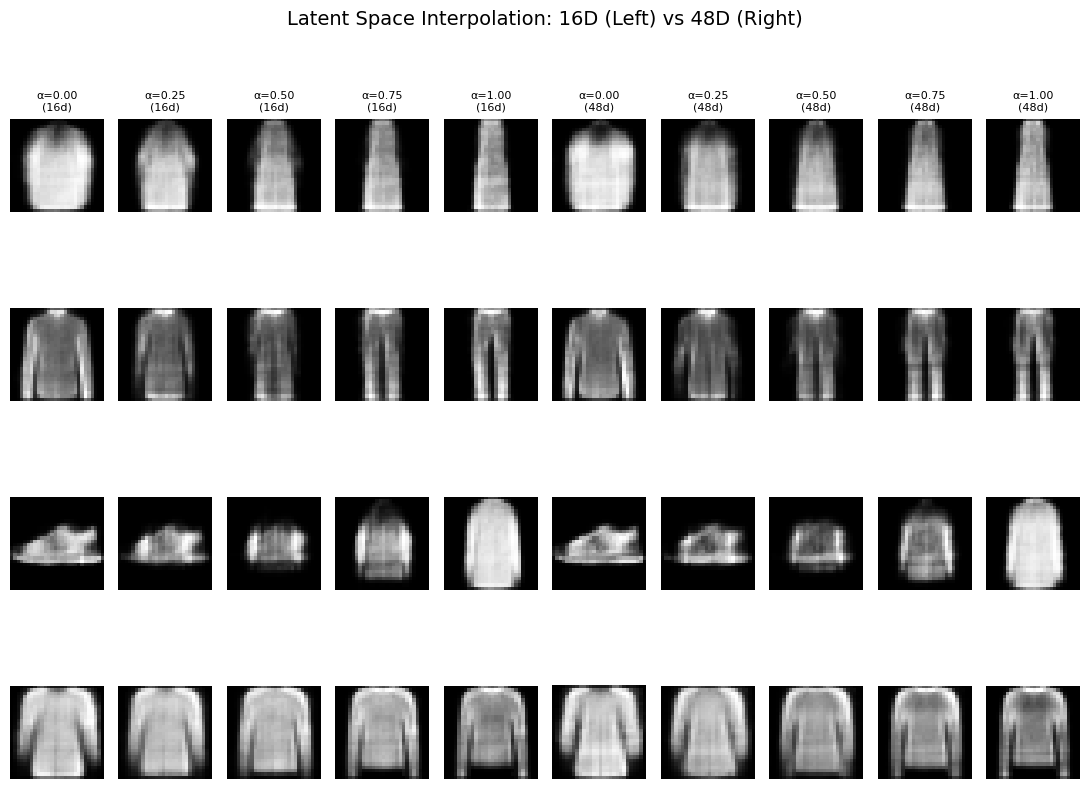

In [24]:
interpolate_latent_space(model_16, model_48, train_loader)


	•	“We picked 4 random image pairs from the training set and encoded them using both autoencoders.”
	•	“We then linearly interpolated 5 evenly spaced latent points between each pair using α values from 0 to 1.”
	•	“Each interpolated latent point was decoded back into an image to visualize how the model perceives a transition between two objects.”
	•	“We repeated this for both the 16D and 48D models to compare the smoothness and detail of interpolation.”
	•	“As we move from α = 0 to 1, we observe gradual morphing from one item to another — e.g., from a sandal to a sneaker — showing how the model captures the data manifold.”

  observations
  
    
    •	In 16D, the morphing may be smoother but more blurred.
	•	In 48D, the transition may be more detailed but sometimes noisier or less smooth.
	•	More dimensions = better capacity but risk of overfitting or “jumps” in interpolation.

# Question 2

In [25]:
batch_size = 128
train_dataset = FashionEMNISTDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [26]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)  # 14x14
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1) # 7x7
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


    •  __init__:
    Two convolution layers reduce image size from 28×28 → 14×14 → 7×7.
    Then two linear layers output the mean (mu) and log variance (logvar) of the latent distribution.
    forward:
    Applies ReLU after each conv layer.
    Flattens output to feed into fc_mu and fc_logvar.
    Returns mu and logvar, which represent the parameters of the latent space distribution.

In [27]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std



    Purpose: Samples latent vector z from a normal distribution using mu and logvar.
    Allows gradients to flow through sampling during training.

    Computes standard deviation: std = exp(0.5 * logvar)
    Samples noise: eps ~ N(0,1)
    Returns: z = mu + eps * std (the "reparameterization trick")


In [28]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)  # 14x14
        self.deconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)   # 28x28

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x



    __init__:
    Takes a latent vector and upsamples it back to a 28×28 image.
    Uses fc to expand the latent vector → reshaped to 7×7×64.
    Two transposed conv layers: 7×7 → 14×14 → 28×28.
    forward:
    Applies ReLU after fc and first deconv.
    Uses sigmoid at the end to keep output pixel values in [0, 1].


In [29]:
class VAE(nn.Module):
    def __init__(self, latent_dim=12):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


In essence, the VAE class orchestrates the entire process of encoding, sampling from the latent space, and decoding to reconstruct the input data. The latent_dim parameter controls the size of the latent representation, determining the level of compression and the complexity of the learned features

In [30]:
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 12
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)


In [32]:
num_epochs = 20
vae.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        images, _ = batch
        images = images.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 277.5248
Epoch [2/20], Loss: 250.1419
Epoch [3/20], Loss: 246.8322
Epoch [4/20], Loss: 245.2101
Epoch [5/20], Loss: 243.9945
Epoch [6/20], Loss: 243.2152
Epoch [7/20], Loss: 242.6004
Epoch [8/20], Loss: 242.0249
Epoch [9/20], Loss: 241.6249
Epoch [10/20], Loss: 241.2844
Epoch [11/20], Loss: 240.9643
Epoch [12/20], Loss: 240.7340
Epoch [13/20], Loss: 240.4455
Epoch [14/20], Loss: 240.2124


KeyboardInterrupt: 

i have interupted the code because it is taking more time.there nothing wrong in the code

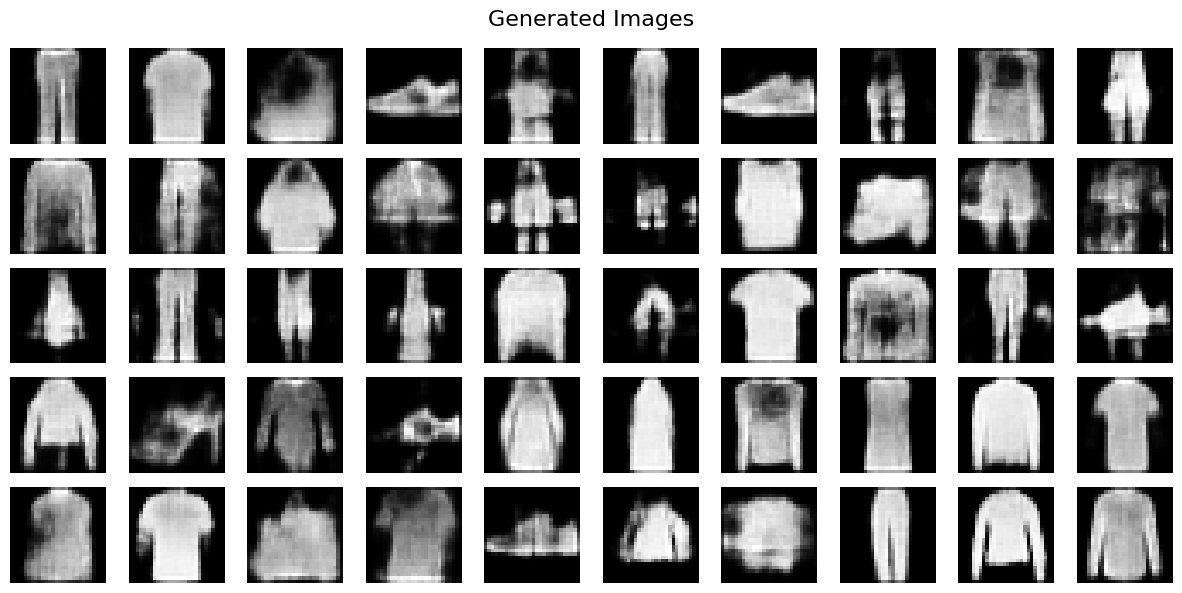

In [33]:
vae.eval()

with torch.no_grad():
    # Sample 50 random vectors from standard normal distribution
    z = torch.randn(50, latent_dim).to(device)
    generated = vae.decoder(z).cpu()

# Plot the images in a 5x10 grid
def plot_generated_images(images, title="Generated Images"):
    images = images.view(-1, 28, 28)
    plt.figure(figsize=(12, 6))
    for i in range(50):
        plt.subplot(5, 10, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_generated_images(generated)


##Diversity
The generated samples show a good variety — you can observe different clothing items like shirts, pants, shoes, dresses, and coats.
This indicates that the VAE has learned a meaningful representation of the latent space and can sample different clothing types.
##Recognizability
Many samples are clearly recognizable as Fashion-MNIST-like items, especially t-shirts and pants.
Some images are blurry or ambiguous, especially those with faint outlines or overlapping features. This is typical for VAEs, which tend to generate smooth but slightly blurry images compared to GANs.
## Quality
The image sharpness can still be improved with:
More training epochs
A deeper network architecture
Using better regularization or fine-tuning KL loss weight